# **Práctica 1: KNN y selección de atributos**

**Eva Blazquez y Gabriela Damas**

## **1. Implementación y uso de KNN**

**a) Descargue los datos del siguiente problema relacionado con el cáncer de mama:**

In [1]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

**b) Preprocese el dataset siguiendo estos pasos: (1) separe los atributos de la etiquetas; (2) divida los datos en una partición con el 70 % de los puntos para training y el 30 % de los puntos para test; (3) normalice los datos**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# (1) Separar atributos de las etiquetas
X, y = data.data, data.target

# (2) Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# (3) Escalar (sin asumir normalidad): MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**c) Si hubiera datos ausentes (missing values) y estos se completaran, ¿cómo cree que influiría el orden en el que se realizan las operaciones de normalizar y completar? ¿Qué pasaría si primero se completan los datos ausentes y luego se normaliza? ¿Y si primero se normaliza y luego se realiza la partición training-test?**

**Respuesta:**  
- Si primero completamos los missing values y luego normalizamos, la normalización se hace sobre datos completos, lo cual es correcto.
- Si primero normalizamos y luego completamos, los valores imputados no estarán correctamente escalados respecto al resto.
- Si primero normalizamos y luego partimos en train/test, puedes tener "fugas de información" porque la media y desviación estándar se calculan usando datos de test.

**d) A continuación, complete la clase KNNClassifier, cuyos atributos son el número de vecinos y una función distancia (una función cuyas entradas son dos vectores de la misma dimensión, y cuya salida es un número real positivo). Complete el constructor y los métodos fit y predict.**

[Ver KNNClassifier.py](./KNNClassifier.py)

**e) Utilice la clase anterior para predecir las etiquetas de los datos de test, con un número de vecinos $k$, fijo pero arbitrario.**

In [3]:
from KNNClassifier import KNNClassifier
from sklearn.metrics import accuracy_score

knn = KNNClassifier(k=5)
knn.fit(X_train_scaled, y_train)
y_predcustom = knn.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_predcustom))

Accuracy: 0.9707602339181286


**f) Responda a la siguiente pregunta: ¿Qué ocurriría si hubiera un desbalanceo de clases en el conjunto de entrenamiento? Si esto supone un problema, ¿podría proporcionar una solución?**

**Respuesta:** Si hay desbalanceo de clases, KNN puede estar sesgado hacia la clase mayoritaria. Una solución es ponderar el voto de los vecinos por la inversa de la distancia o usar técnicas de sobremuestreo/submuestreo, o ajustar el umbral de decisión.

**g) Responda a la siguiente pregunta: ¿Cuál es el coste en memoria del algoritmo KNN? ¿Se le ocurre alguna forma de reducirlo?**

**Respuesta:** KNN almacena todo el conjunto de entrenamiento, por lo que el coste en memoria es $O(n \cdot d)$, siendo $n$ el número de muestras y $d$ el número de atributos. Para reducirlo se pueden usar prototipos (condensed KNN), clustering, o reducción de dimensionalidad.

**h) Utilice la función KNeighborsClassifier de la biblioteca de sklearn y, para el mismo número de vecinos $k$ prediga las etiquetas del conjunto de test $y_{\text{predsk}}$. Si $y_{\text{predsk}}$ son las prediciones de su modelo, ¿cuál es el error medio entre las predicciones $y_{\text{predsk}}$ e $y_{\text{predcustom}}$? ¿Por qué?**

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

knn_sk = KNeighborsClassifier(n_neighbors=5)
knn_sk.fit(X_train_scaled, y_train)
y_predsk = knn_sk.predict(X_test_scaled)
print("Error medio entre predicciones:", mean_squared_error(y_predcustom, y_predsk))

Error medio entre predicciones: 0.0


**i) Se encuentra usted a un individuo que afirma que, en vez de utilizar KNN, el prefiere usar la siguiente alternativa. Para predecir la etiqueta del punto $x$, toma los tres puntos más cercanos a $x$ en el conjunto de training. Si las distancias de estos tres puntos al punto $x$ son $d_1$, $d_2$ e $d_3$, y sus respectivas etiquetas son $y_1$, $y_2$ e $y_3$, la predicción vendrá dada por**

$$
f(x) = \operatorname{sign} \left( \sum_{i=1}^{3} \frac{y_i}{d_i} \right).
$$

**¿Considera que este método es mejor que KNN con $k = 3$? ¿Por qué?**

_Inciso:_ En KNN “clásico”, cada uno de los $k=3$ vecinos cercanos votaría con el mismo peso y se elegiría la clase mayoritaria. La idea propuesta es una variante de KNN donde cada vecino contribuye con un peso inverso a su distancia $(\frac{1}{d})$.

Si el punto a clasificar es muy próximo a un ejemplo de una clase y lejano a ejemplos de la otra, tiene sentido darle más importancia al cercano. Esto ayuda cuando hay mezcla de clases alrededor del punto y cuando la cercanía es un indicador fuerte de pertenencia a la clase correcta. Sin embargo, si alguna distancia es muy pequeña (casi 0), $\frac{1}{d}$ se dispara y la predicción queda dominada por ese único vecino, comportándose casi como $k=1$.

**Respuesta:** Depende. En muchos problemas puede igualar o mejorar ligeramente, pero también puede volverse más sensible a outliers y a mediciones de distancia ruidosas. La recomendación práctica es validarlo con validación cruzada en los datos concretos y escoger la variante que mejor funcione en promedio.

---

## **2. Optimización de KNN**

**a) Encuentre, utilizando validación cruzada, el número de vecinos óptimos, $k_{\text{opt}}$.**

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Evitar warnings de sklearn

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNNClassifier())
])

param_grid = {'knn__k': list(range(1, 31))}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

k_opt = grid.best_params_['knn__k']
print(f"k óptimo: {k_opt}")

k óptimo: 5


**b) De la métrica de accuracy sobre el conjunto de test del clasificador KNN usando el valor $k_{\text{opt}}$ obtenido.**

In [6]:
best_knn_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNNClassifier(k=k_opt))
])

best_knn_pipe.fit(X_train, y_train)
y_pred = best_knn_pipe.predict(X_test)
print("Accuracy sobre el conjunto de test:", accuracy_score(y_test, y_pred))

Accuracy sobre el conjunto de test: 0.9707602339181286


**c) ¿Cree que el valor $k_{\text{opt}}$ encontrado es el que proporciona mejor accuracy en el conjunto de test?**

**Respuesta:** No necesariamente. $k_{\text{opt}}$ es el valor que mejor funcionó en validación cruzada dentro del conjunto de entrenamiento, por lo que es el que se espera que generalice mejor “en promedio”. Sin embargo, el conjunto de test es una única muestra aleatoria: por variabilidad, puede ocurrir que otro $k$ dé una accuracy ligeramente mayor en ese test concreto.

La buena práctica es: elegir $k_{\text{opt}}$ solo con validación cruzada en train (dentro de un Pipeline para evitar fugas), reentrenar con todo el train usando $k_{\text{opt}}$ y evaluar una única vez en test.

**d) Muestre en una gráfica el accuracy frente al número de vecinos, tanto para el conjunto de training como para el de test.**

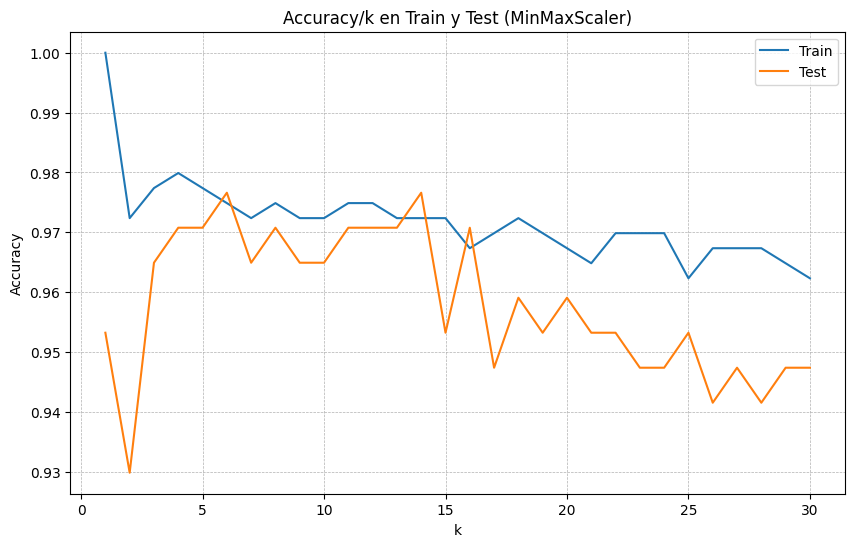

In [7]:
import matplotlib.pyplot as plt

k_values = list(range(1, 31))
train_acc = []
test_acc = []

for k in k_values:
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('knn', KNNClassifier(k=k))
    ])
    pipe.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, pipe.predict(X_train)))
    test_acc.append(accuracy_score(y_test, pipe.predict(X_test)))

plt.figure(figsize=(10,6))
plt.plot(k_values, train_acc, label='Train')
plt.plot(k_values, test_acc, label='Test')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy/k en Train y Test (MinMaxScaler)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

**e) Repita los experimentos anteriores utilizando la distancia de Minkowski para $p ∈ {1, 2, 10}$.**

In [8]:
p_values = [1, 2, 10]
k_values = list(range(1, 31))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

k_opt_dict = {}
best_by_p = {}

for p in p_values:
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('knn', KNNClassifier(p=p))
    ])
    grid = GridSearchCV(pipe, {'knn__k': k_values}, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    k_opt = grid.best_params_['knn__k']
    k_opt_dict[p] = k_opt
    best_by_p[p] = grid.best_estimator_
    print(f"Para p={p}, el k óptimo = {k_opt}")

Para p=1, el k óptimo = 6
Para p=2, el k óptimo = 5
Para p=10, el k óptimo = 8


In [9]:
# Evaluación en test usando el MISMO preprocesado (Pipeline)
for p in p_values:
    y_test_pred = best_by_p[p].predict(X_test)
    print(f"Para p={p}, el test accuracy = {accuracy_score(y_test, y_test_pred):.4f}")

Para p=1, el test accuracy = 0.9649
Para p=2, el test accuracy = 0.9708
Para p=10, el test accuracy = 0.9415


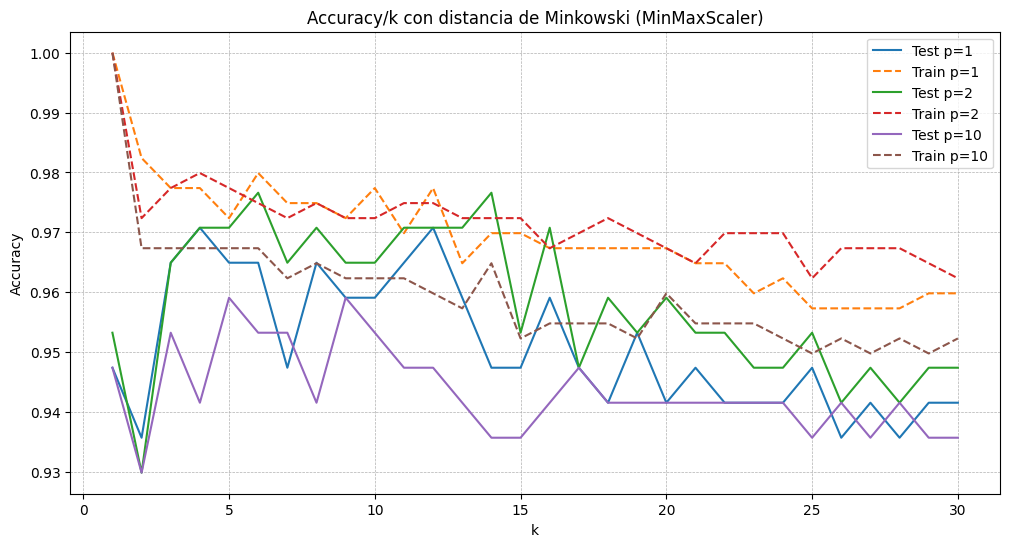

In [10]:
# Curvas Accuracy/k para cada p (siempre con Pipeline)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for p in p_values:
    train_acc, test_acc = [], []
    for k in k_values:
        pipe = Pipeline([
            ('scaler', MinMaxScaler()),
            ('knn', KNNClassifier(k=k, p=p))
        ])
        pipe.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, pipe.predict(X_train)))
        test_acc.append(accuracy_score(y_test, pipe.predict(X_test)))

    plt.plot(k_values, test_acc, label=f'Test p={p}')
    plt.plot(k_values, train_acc, linestyle='--', label=f'Train p={p}')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy/k con distancia de Minkowski (MinMaxScaler)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

**f) ¿Cómo afecta el valor de $p$ a los resultados? ¿Qué $p$ cree que es mejor?**

**Respuesta:**  
El parámetro ppp en la distancia de Minkowski afecta cómo se mide la similitud entre instancias en el clasificador KNN. En este caso, se probaron los valores $p=1$, $p=2$ y $p=10$. Los resultados muestran que $p=1$ obtuvo la mejor precisión en validación cruzada (0.9774), mientras que $p=2$ logró el mejor rendimiento en el conjunto de test (0.9591). Por otro lado, $p=10$ tuvo el peor desempeño en ambas métricas.

Las curvas de precisión confirman que tanto $p=1$ como $p=2$ ofrecen resultados estables y altos para valores bajos de kkk, mientras que $p=10$ muestra mayor variabilidad y menor precisión. En conclusión, aunque $p=1$ fue ligeramente mejor en validación, el valor $p=2$ generaliza mejor, por lo que se considera la mejor opción para este problema.

---

## **3.Selección de atributos**

**A continuación procederemos a la reducción de la dimensión de los datos.**

**a) Usando el método VarianceThreshold de sklearn.feature selection para cierto umbral fijo u, elimine los atributos que no superen dicho umbral.**

In [11]:
from sklearn.feature_selection import VarianceThreshold

u = 0.0001
selector = VarianceThreshold(threshold=u)
X_train_vt = selector.fit_transform(X_train)
X_test_vt = selector.transform(X_test)

print(f"Número de características originales: {X_train.shape[1]}")
print(f"Número de características seleccionadas: {X_train_vt.shape[1]}")

Número de características originales: 30
Número de características seleccionadas: 25


> Nota sobre el orden (importante): VarianceThreshold debe aplicarse antes de escalar. Si escalas primero (con StandardScaler o MinMaxScaler), alteras la varianza y el umbral u pierde sentido. El orden correcto que estáis usando es: selección por varianza → escalado → KNN. Además, como regla general cuando no puedes asumir normalidad, utiliza MinMaxScaler en lugar de StandardScaler.

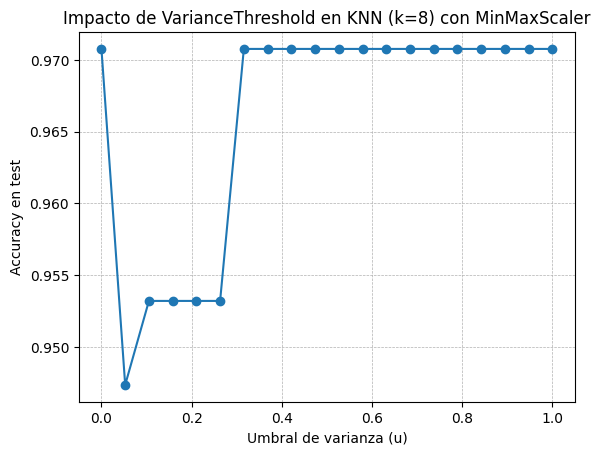

In [12]:
import numpy as np

k_fixed = grid.best_params_['knn__k']
us = np.linspace(0, 1, 20)
accuracies = []

for u in us:
    pipe = Pipeline([
        ('select', VarianceThreshold(threshold=u)),  # selección SOBRE X original
        ('scaler', MinMaxScaler()),                 # escalar SOLO las seleccionadas sin asumir normalidad
        ('knn', KNNClassifier(k=k_fixed))
    ])
    pipe.fit(X_train, y_train)
    y_test_pred = pipe.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_test_pred))

plt.plot(us, accuracies, marker='o')
plt.xlabel("Umbral de varianza (u)")
plt.ylabel("Accuracy en test")
plt.title(f"Impacto de VarianceThreshold en KNN (k={k_fixed}) con MinMaxScaler")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

**c) ¿Tienen sentido los casos $u=0$ y $u=1$?**

**Respuesta:** Cuando $u=0$, ninguna de las columna se descarta, porque todas tienen varianza mayor a cero, lo que significa que se utilizan todas las características originales, proporcionando una referencia del rendimiento máximo del modelo. En cambio, cuando $u=1$, solo se mantienen columnas con varianza igual o mayor a 1, lo que elimina la mayoría de las características y provoca una caída notable en la exactitud del modelo, como se observa en la gráfica. 

Estos casos límite permiten interpretar mejor el comportamiento del modelo: el valor óptimo de $u$ estará en algún punto intermedio, donde se eliminan atributos irrelevantes pero se conservan los más importantes para mantener un buen desempeño.

**d) Ahora seleccione los mejores atributos del conjunto de datos utilizando SelectKBest de la librería scikit-learn. Siga los siguientes pasos:**

1) **Importe el método SelectKBest:**

In [13]:
from sklearn.feature_selection import SelectKBest

2) **Utilice una estadística univariada como f classif para la selección de atributos:**

In [14]:
from sklearn.feature_selection import f_classif

3) **Seleccione los mejores K atributos:**

In [15]:
selector = SelectKBest(score_func=f_classif, k=10) # k es el número de atributos a seleccionar (ejemplo = 10)
X_train_kbest = selector.fit_transform(X_train, y_train)
X_test_kbest = selector.transform(X_test)

In [16]:
k_fijo = k_opt

pipe = Pipeline([
    ('select', SelectKBest(score_func=f_classif)),  # selección ANTES de escalar
    ('scaler', MinMaxScaler()),
    ('knn', KNNClassifier(k=k_fijo))                # KNN con k fijo
])

param_grid = {'select__k': list(range(1, X_train.shape[1] + 1))}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gridK = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gridK.fit(X_train, y_train)

best_K = gridK.best_params_['select__k']
print(f"Mejor K por CV: {best_K}")

# Evaluación única en test
y_test_pred = gridK.best_estimator_.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Accuracy en test con K={best_K} y k={k_fijo}: {test_acc:.4f}")

Mejor K por CV: 24
Accuracy en test con K=24 y k=8: 0.9649


**f) A continuación implemente el método de selección de atributos mRMR. Para ello, complete el archivo mRMR.py.**

[Ver mRMR.py](./mRMR.py)

**g) ¿Cuál es su mejor valor de k?**

In [17]:
import pandas as pd
from mRMR import mRMR

resultados = []
max_K = 30
mrmr_full = mRMR(n_features=max_K)
mrmr_full.fit(X_train, y_train)
ranking = mrmr_full.selected_features_

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNNClassifier())
])

param_grid = {'knn__k': list(range(1, 31))} 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for K in range(1, max_K + 1):
    X_train_mrmr = X_train[:, ranking[:K]]
    X_test_mrmr  = X_test[:, ranking[:K]]

    grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_mrmr, y_train)

    resultados.append({
        "K_atributos": K,
        "mejor_k_vecinos": grid.best_params_['knn__k'],
        "accuracy_cv": grid.best_score_,
        "accuracy_test": grid.score(X_test_mrmr, y_test)
    })

df_resultados = pd.DataFrame(resultados)
best_row = df_resultados.loc[df_resultados['accuracy_test'].idxmax()]

mejor_k = best_row['mejor_k_vecinos']

print("El mejor valor de k es:", mejor_k)
print("Con K_atributos =", best_row['K_atributos'],
      "y accuracy_test =", best_row['accuracy_test'])

El mejor valor de k es: 7.0
Con K_atributos = 22.0 y accuracy_test = 0.9766081871345029


**h) ¿Cuál es el papel de la información mutua en el método mRMR? ¿Se podría sustituir por otra métrica?**

La información mutua (IM) es la métrica central del método mRMR. Se utiliza para medir:

- **Relevancia:** cuánto aporta cada característica respecto a la variable objetivo, mediante la información mutua entre cada atributo y la clase.

- **Redundancia:** cuánto se solapan las características entre sí, mediante la información mutua entre pares de atributos.

Este enfoque permite seleccionar características que sean informativas y no repetitivas. La IM tiene la ventaja de capturar dependencias no lineales, lo que la hace más potente que métricas como la correlación.

Aunque se podría sustituir por otras métricas como la correlación, el F-test o el Chi², estas alternativas no capturan relaciones complejas y no están alineadas con la formulación original de mRMR. Por tanto, sí se puede sustituir, pero no sería el método mRMR en sentido estricto.


**i) ¿Qué método de selección de atributos, de los dos utilizados, considera que es mejor?**

**mRMR** es más teórico, eficiente y explicativo. Es útil para reducir el espacio de búsqueda y evitar redundancia.

**KNN** permite validar directamente qué atributos funcionan mejor con el modelo, aunque es más costoso computacionalmente.

En general, mRMR es mejor como paso inicial para reducir la dimensionalidad de forma informada. Posteriormente, se puede afinar la selección usando KNN y validación cruzada.

Por tanto, la combinación de ambos métodos es la más recomendable: primero mRMR para filtrar, luego KNN para validar.